good intro ex of pm.Censored in PyMC: 
https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html

Terse example:
https://discourse.pymc.io/t/simple-exponential-survival-function/4961/8

McElreath Lecture:
https://www.youtube.com/watch?v=Zi6N3GLUJmw&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus&index=10

I'm trying out a gamma distribution now.

In [283]:
import pymc as pm
from pymc.distributions.distribution import Continuous
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import gamma

In [284]:
RANDOM_SEED = 3
plt.rcParams['figure.constrained_layout.use'] = True

## Import

In [285]:
data = pd.read_csv("Horn_Crab Development Data for LOL_mod.csv", 
                   dtype={
                    # "C or T": "category"
                   },
                   converters={
                       "C or T": str.strip
                   })
data["C or T"] = data["C or T"].astype("category")

In [286]:
data.head()

,Crab #,C or T,Carapace Length,Carapace width,Collection Date,Death date,# of days alive,Enviro Plastics present Y/N,# of Yellow fibers ingested,# of days with viable eggs,Reach Larval Stage Y/N,# of stages,Egg Stage end of exp
0,1,c,16.04,12.54,8/4/18,10/14/18,71,N,0,21,y,1,8
1,2,c,21.30,17.15,8/4/18,10/14/18,71,N,0,71,y,5,3
2,3,c,17.13,12.00,8/4/18,10/14/18,71,N,0,24,y,4,5
3,4,c,25.49,19.22,8/4/18,10/14/18,71,N,0,71,y,4,4
4,5,c,15.02,12.46,8/4/18,10/14/18,71,N,0,24,y,10,8


In [287]:
data.dtypes

Crab #                            int64
C or T                         category
Carapace Length                 float64
Carapace width                  float64
Collection Date                  object
Death date                       object
# of days alive                   int64
Enviro Plastics present Y/N      object
# of Yellow fibers ingested       int64
# of days with viable eggs        int64
Reach Larval Stage Y/N           object
# of stages                       int64
Egg Stage end of exp              int64
dtype: object

In [288]:
data["C or T"].cat.codes

0     0
1     0
2     0
3     0
4     0
     ..
59    1
60    1
61    1
62    1
63    1
Length: 64, dtype: int8

In [289]:
data["C or T"].cat.codes.unique()

array([0, 1], dtype=int8)

death == 0 means crab was censored, so we know it survived at least 71 days,
so its probability is all of the probability density for your dist that is
above the censoring point, i.e. 1 - CDF(censoring pt, dist).
If your obs wasn't censored, you need to make sure its corresponding `upper` value is greater than it, so that it takes the PDF value at obs=x, and not the 1 - CDF value (ref: https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html). Here, I'm setting it to `np.Inf`.
c.f. https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html

IN THIS CASE, because all censoring happened at Tmax and no crab died at Tmax, I could've just set `upper=max(data["# of days alive"])`. All censored would've had that 1-CDF prob dens, and the dead would've had their regular old PDF. c.f. https://www.pymc.io/projects/examples/en/latest/survival_analysis/censored_data.html

In [290]:
data["death"] = [0 if x == 71 else 1 for x in data["# of days alive"]]
data["c_or_t_grp"] = data["C or T"].cat.codes

data["upper"] = data.apply(
    lambda row: row["# of days alive"] if row["death"] == 0 else np.Inf, 
    axis=1)

In [291]:
data.head()

,Crab #,C or T,Carapace Length,Carapace width,Collection Date,Death date,# of days alive,Enviro Plastics present Y/N,# of Yellow fibers ingested,# of days with viable eggs,Reach Larval Stage Y/N,# of stages,Egg Stage end of exp,death,c_or_t_grp,upper
0,1,c,16.04,12.54,8/4/18,10/14/18,71,N,0,21,y,1,8,0,0,71.0
1,2,c,21.30,17.15,8/4/18,10/14/18,71,N,0,71,y,5,3,0,0,71.0
2,3,c,17.13,12.00,8/4/18,10/14/18,71,N,0,24,y,4,5,0,0,71.0
3,4,c,25.49,19.22,8/4/18,10/14/18,71,N,0,71,y,4,4,0,0,71.0
4,5,c,15.02,12.46,8/4/18,10/14/18,71,N,0,24,y,10,8,0,0,71.0


In [292]:
{x[0]: x[1] for x in data.loc[:, ["C or T", "c_or_t_grp"]].drop_duplicates().to_numpy()}

{'c': 0, 't': 1}

## Model def

In [293]:
coords = {
    "grp": ["c", "t"],
}

BETA_SIGMA = 0.02
BETA_SIGMA = 0.02

with pm.Model(coords=coords) as model:
    # Data
    days_to_event_data = pm.ConstantData("days_to_event_data", data["# of days alive"])
    upper_data = pm.ConstantData("upper_data", data["upper"])
    grp_data = pm.ConstantData("grp_data", data["c_or_t_grp"])

    # Priors
    alpha = pm.Gamma("alpha (shape)", alpha=2, beta=1, dims="grp")
    beta = pm.HalfNormal("beta (rate)", sigma=BETA_SIGMA, dims="grp")
    # The LogNormal prior does worse it seems.
    # beta = pm.LogNormal("beta (rate)", mu=-4, sigma=1, dims="grp")

    # lik
    Y_obs = pm.Censored("Y_obs", 
                        dist=pm.Gamma.dist(alpha=alpha[grp_data], beta=beta[grp_data]),
                        lower=None,
                        upper=upper_data,
                        observed=days_to_event_data)
    
    # derived vars
    mean = pm.Deterministic("mean", alpha / beta, dims="grp")
    diff = pm.Deterministic("control - treatment", 
                            (alpha[0] / beta[0]) - (alpha[1] / beta[1]))
    # this info is already in mu, but in mu it repeats for n obs times.
    # exp_alpha = pm.Deterministic("exp_alpha", pm.math.exp(alpha), dims="grp")
    # log_diff = pm.Deterministic("log c-t", pm.math.log(diff))

/Users/Scott/micromamba/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:291: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


### Checking the model before usage

#### Graphviz
Does the model look right?

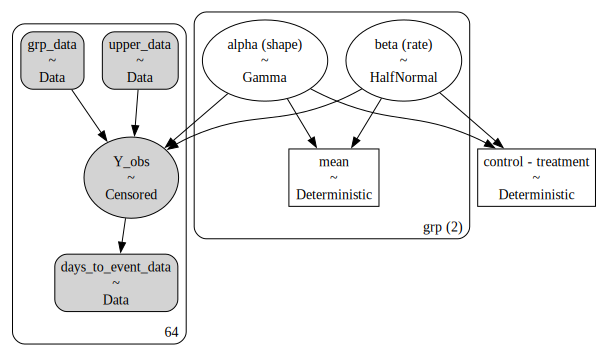

In [294]:
pm.model_to_graphviz(model)

In [295]:
with model:
    idata_prior = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [Y_obs, alpha (shape), beta (rate)]


In [296]:
idata_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [297]:
idata_prior.prior["beta (rate)"][0,:,0].to_dataframe().describe()

,chain,beta (rate)
count,500.0,500.000000
mean,0.0,0.015321
std,0.0,0.011443
min,0.0,0.000008
25%,0.0,0.006003
50%,0.0,0.012911
75%,0.0,0.023031
max,0.0,0.052131


In [298]:
c_alphas_prior = idata_prior.prior["alpha (shape)"][0,:100,0].to_numpy().reshape((-1, 1))
t_alphas_prior = idata_prior.prior["alpha (shape)"][0,:100,1].to_numpy().reshape((-1, 1))
c_betas_prior = idata_prior.prior["beta (rate)"][0,:100,0].to_numpy().reshape((-1, 1))
t_betas_prior = idata_prior.prior["beta (rate)"][0,:100,1].to_numpy().reshape((-1, 1))

In [299]:
c_alphas_prior_all = idata_prior.prior["alpha (shape)"][0,:,0]
t_alphas_prior_all = idata_prior.prior["alpha (shape)"][0,:,1]
c_betas_prior_all = idata_prior.prior["beta (rate)"][0,:,0]
t_betas_prior_all = idata_prior.prior["beta (rate)"][0,:,1]
# avgs = alpha/beta
(
(c_alphas_prior_all / c_betas_prior_all)
    .to_dataframe(name="ctrl avg (alpha/beta)")
    .describe(), 
(t_alphas_prior_all / t_betas_prior_all)
    .to_dataframe(name="trt avg (alpha/beta)")
    .describe()
)

(       chain  ctrl avg (alpha/beta)
 count  500.0             500.000000
 mean     0.0             974.578831
 std      0.0           11877.551952
 min      0.0               2.341228
 25%      0.0              63.227607
 50%      0.0             136.403868
 75%      0.0             323.060816
 max      0.0          264243.103535,
        chain  trt avg (alpha/beta)
 count  500.0            500.000000
 mean     0.0            624.174901
 std      0.0           3244.775355
 min      0.0              3.136638
 25%      0.0             61.075028
 50%      0.0            131.129565
 75%      0.0            284.659849
 max      0.0          58473.023892)

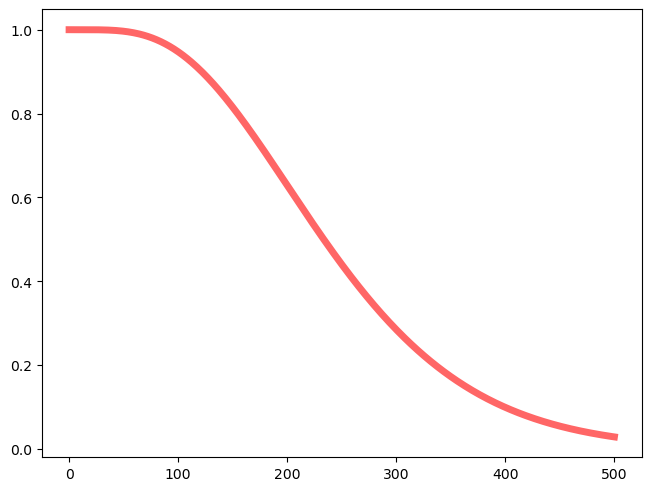

In [300]:
a = 5
b = 0.02
scale = 1/b
x = np.linspace(0, 500, 500)

fig, ax = plt.subplots(1, 1)
ax.plot(x, gamma.sf(x, a, scale=scale),
       'r-', lw=5, alpha=0.6, label='gamma ccdf')

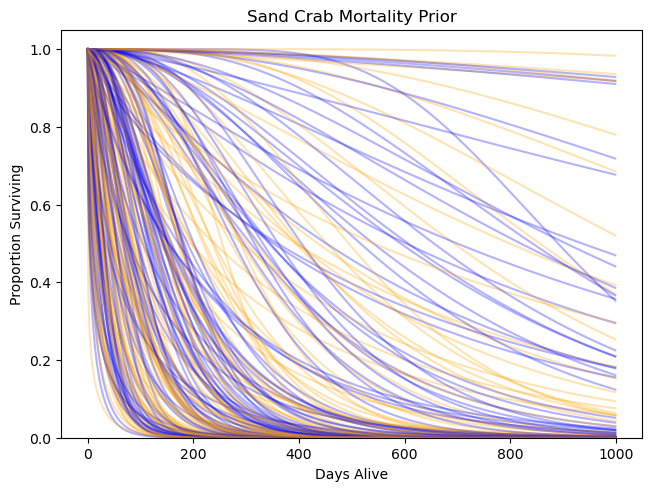

In [301]:
t = np.arange(1000).reshape((1, -1))
x = np.linspace(0, 1000, 1000)
sample_curves_c = gamma.sf(t, a=c_alphas_prior, scale=(1 / c_betas_prior))
sample_curves_t = gamma.sf(t, a=t_alphas_prior, scale=(1 / t_betas_prior))

_, ax = plt.subplots()
ax.set_ylim(0, 1.05)

ax.set_title("Sand Crab Mortality Prior")
ax.set_xlabel("Days Alive")
ax.set_ylabel("Proportion Surviving")

for i in range(sample_curves_c.shape[0]):
    t_artist = ax.plot(t.reshape(-1), 
                       sample_curves_t[i,:], 
                       color="blue", 
                       alpha=0.3)
    c_artist = ax.plot(t.reshape(-1), 
                       sample_curves_c[i,:], 
                       color="orange", 
                       alpha=0.3)

### Sampling

In [302]:
with model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha (shape), beta (rate)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


### Summaries, Plots

In [303]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

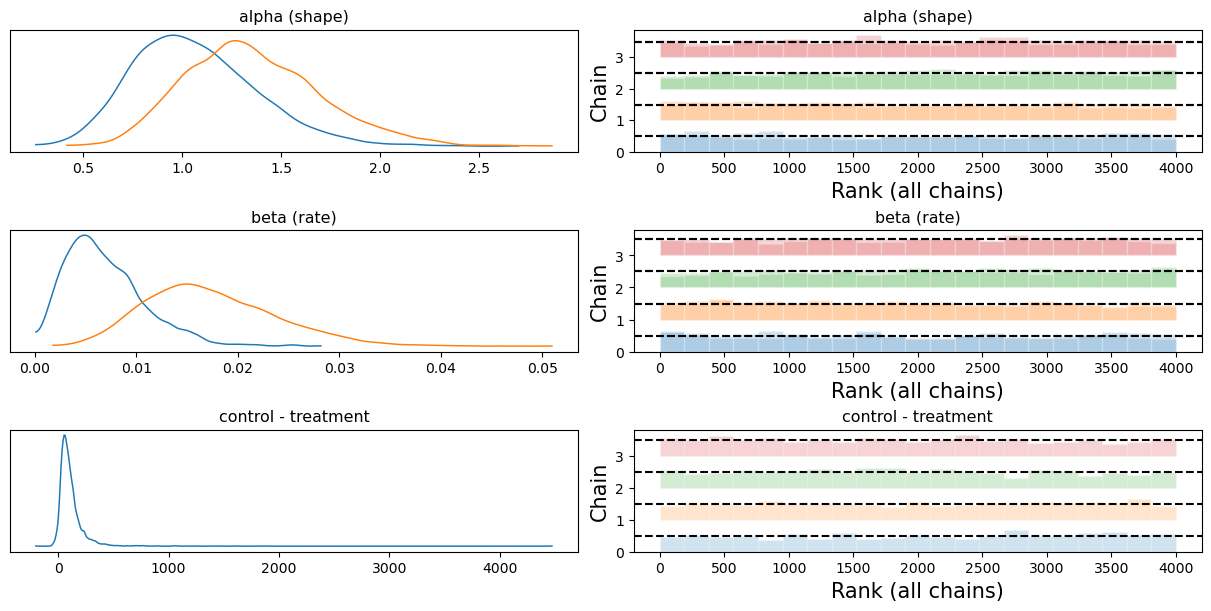

In [304]:
ax = az.plot_trace(idata,
                   var_names=["~mean"],
            #   legend=True,
              combined=True,
            #   transform=np.exp,
              kind="rank_bars")

# ax[0][1].set_visible(False)
# ax[1][1].set_visible(False)

In [305]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha (shape)[c],1.063,0.313,0.487,1.625,0.007,0.005,1753.0,1597.0,1.0
alpha (shape)[t],1.354,0.341,0.741,1.994,0.009,0.006,1472.0,1795.0,1.0
beta (rate)[c],0.007,0.004,0.001,0.014,0.000,0.000,1713.0,1503.0,1.0
beta (rate)[t],0.017,0.006,0.006,0.029,0.000,0.000,1443.0,1651.0,1.0
mean[c],195.487,132.602,80.959,354.535,3.137,2.219,2140.0,1644.0,1.0
mean[t],83.536,19.949,53.610,119.836,0.419,0.305,2733.0,2220.0,1.0
control - treatment,111.951,133.718,-21.715,285.100,3.173,2.244,2005.0,1667.0,1.0


In [306]:
np.mean(idata.posterior["control - treatment"] > 0)

<xarray.DataArray 'control - treatment' ()> Size: 8B
array(0.97175)

Text(0.5, 0, 'Days Alive')

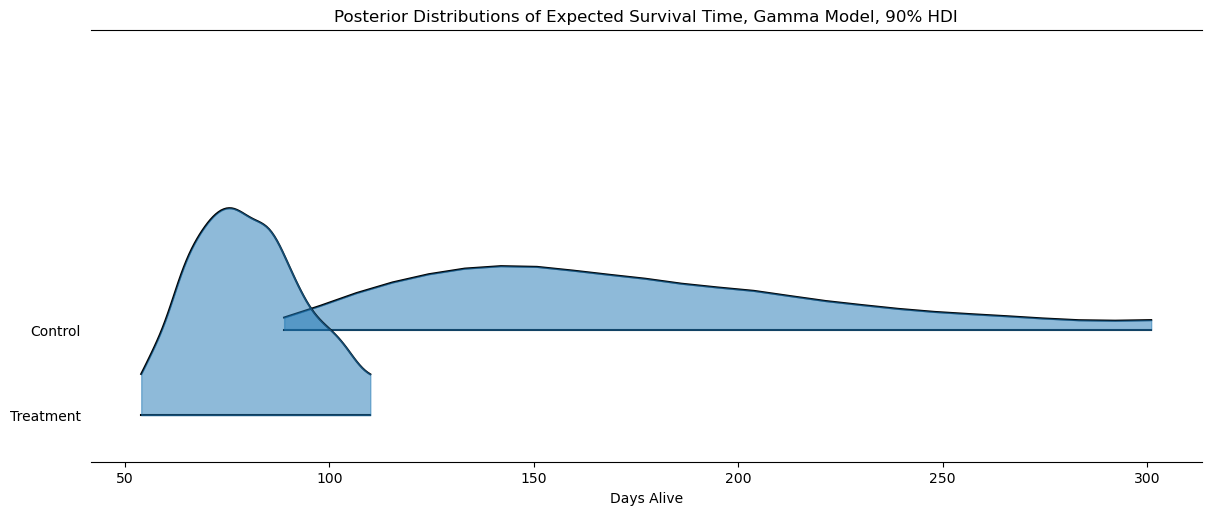

In [307]:
ax = az.plot_forest(idata,
               kind="ridgeplot",
               combined=True,
              var_names=["mean"], 
              ridgeplot_alpha=0.5,
              hdi_prob=0.9)
ax[0].set_title("Posterior Distributions of Expected Survival Time, Gamma Model, 90% HDI")
ax[0].set_yticklabels(["Treatment","Control"])
ax[0].set_xlabel("Days Alive")

Text(0.5, 0, 'Days Alive')

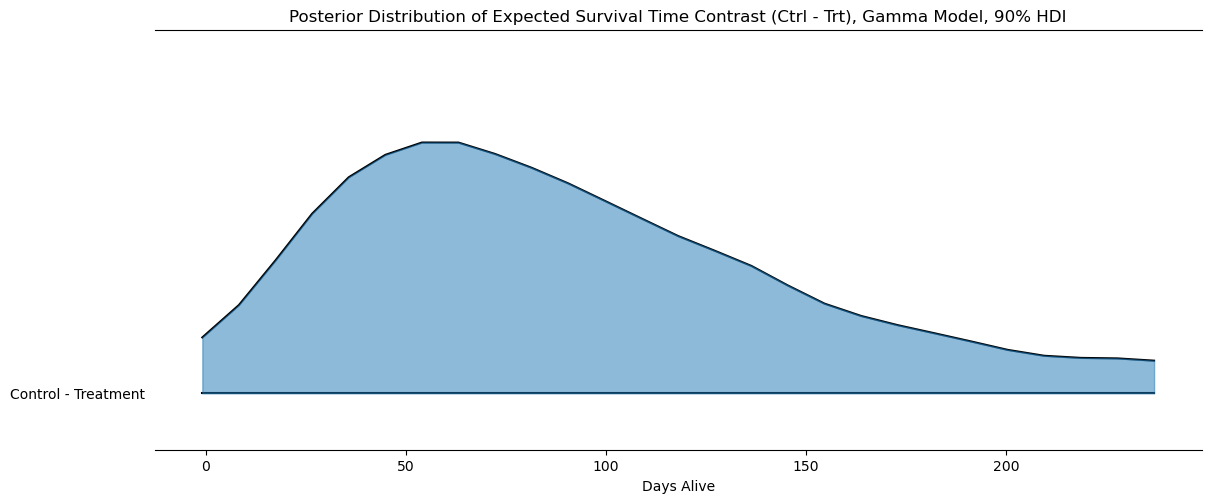

In [308]:
ax = az.plot_forest(idata,
               kind="ridgeplot",
               combined=True,
              var_names=["control - treatment"], 
              ridgeplot_alpha=0.5,
              hdi_prob=0.9)
ax[0].set_title("Posterior Distribution of Expected Survival Time Contrast (Ctrl - Trt), Gamma Model, 90% HDI")
ax[0].set_yticklabels(["Control - Treatment"])
ax[0].set_xlabel("Days Alive")

## Posterior Plots

In [309]:
km_data = pd.read_csv("km_curve.csv")

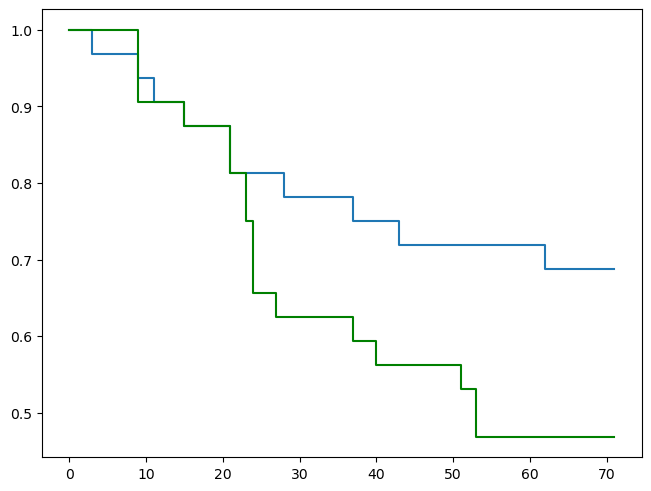

In [310]:
plt.step(x="time", 
         y="pct_surv",
         where="post", 
         data=km_data[km_data["grp"] == "c"])
plt.step(x="time", 
         y="pct_surv",
         where="post", 
         color="g",
         data=km_data[km_data["grp"] == "t"])

In [311]:
c_alphas = idata.posterior["alpha (shape)"][0,:100,0].to_numpy().reshape((-1, 1))
t_alphas = idata.posterior["alpha (shape)"][0,:100,1].to_numpy().reshape((-1, 1))
c_betas = idata.posterior["beta (rate)"][0,:100,0].to_numpy().reshape((-1, 1))
t_betas = idata.posterior["beta (rate)"][0,:100,1].to_numpy().reshape((-1, 1))

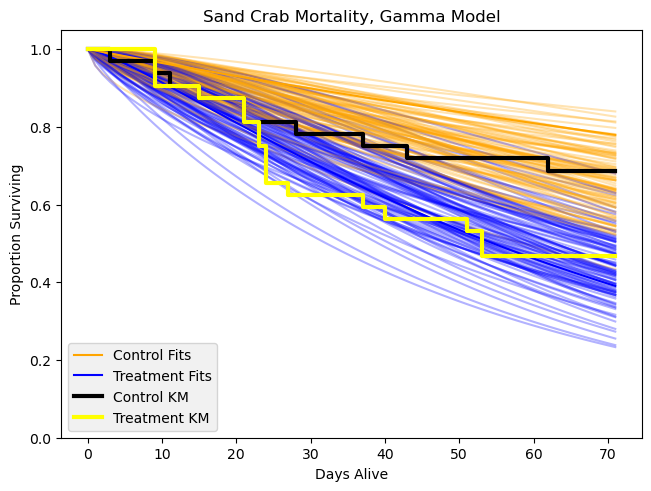

In [312]:
t = np.arange(72).reshape((1, -1))
x = np.linspace(0, 1000, 1000)
sample_curves_c = gamma.sf(t, a=c_alphas, scale=(1 / c_betas))
sample_curves_t = gamma.sf(t, a=t_alphas, scale=(1 / t_betas))

_, ax = plt.subplots()
ax.set_ylim(0, 1.05)

ax.set_title("Sand Crab Mortality, Gamma Model")
ax.set_xlabel("Days Alive")
ax.set_ylabel("Proportion Surviving")

for i in range(sample_curves_c.shape[0]):
    t_artist = ax.plot(t.reshape(-1), 
                       sample_curves_t[i,:], 
                       color="blue", 
                       alpha=0.3)
    c_artist = ax.plot(t.reshape(-1), 
                       sample_curves_c[i,:], 
                       color="orange", 
                       alpha=0.3)

c_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="black",
         linewidth=3, 
         data=km_data[km_data["grp"] == "c"])

t_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="yellow",
         linewidth=3, 
         data=km_data[km_data["grp"] == "t"])

t_artist[0].set_alpha(1)
c_artist[0].set_alpha(1)
ax.legend([c_artist[0], t_artist[0], c_km_artist[0], t_km_artist[0]], 
          ["Control Fits", "Treatment Fits", "Control KM", "Treatment KM"],
          facecolor = "#eee")

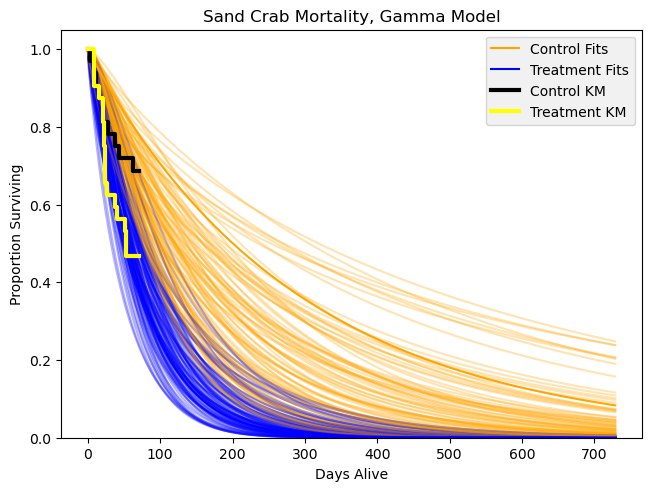

In [313]:
t = np.arange(730).reshape((1, -1))
x = np.linspace(0, 1000, 1000)
sample_curves_c = gamma.sf(t, a=c_alphas, scale=(1 / c_betas))
sample_curves_t = gamma.sf(t, a=t_alphas, scale=(1 / t_betas))

_, ax = plt.subplots()
ax.set_ylim(0, 1.05)

ax.set_title("Sand Crab Mortality, Gamma Model")
ax.set_xlabel("Days Alive")
ax.set_ylabel("Proportion Surviving")

for i in range(sample_curves_c.shape[0]):
    t_artist = ax.plot(t.reshape(-1), 
                       sample_curves_t[i,:], 
                       color="blue", 
                       alpha=0.3)
    c_artist = ax.plot(t.reshape(-1), 
                       sample_curves_c[i,:], 
                       color="orange", 
                       alpha=0.3)

c_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="black",
         linewidth=3, 
         data=km_data[km_data["grp"] == "c"])

t_km_artist = ax.step(x="time", 
         y="pct_surv",
         where="post",
         color="yellow",
         linewidth=3, 
         data=km_data[km_data["grp"] == "t"])

t_artist[0].set_alpha(1)
c_artist[0].set_alpha(1)
ax.legend([c_artist[0], t_artist[0], c_km_artist[0], t_km_artist[0]], 
          ["Control Fits", "Treatment Fits", "Control KM", "Treatment KM"],
          facecolor = "#eee")